In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from prophet import Prophet
from functions import load_data, replace_missing_long, widen_data, feature_engineering, normalize_data

Importing plotly failed. Interactive plots will not work.


In [2]:
data = load_data()

### Task 1B: Data cleaning

In [3]:
# replace missing values with the mean of the variable for that id and day
# data['value'] = data.groupby(['id', 'variable', data['time'].dt.date])['value'].transform(lambda x: x.fillna(x.mean()))
# # replace missing values with the mean of the variable for that id
data['value'] = data.groupby(['id', 'variable'])['value'].transform(lambda x: x.fillna(x.mean()))
data

,Unnamed: 0,id,time,variable,value
0,1,AS14.01,2014-02-26 13:00:00.000,mood,6.000
1,2,AS14.01,2014-02-26 15:00:00.000,mood,6.000
2,3,AS14.01,2014-02-26 18:00:00.000,mood,6.000
3,4,AS14.01,2014-02-26 21:00:00.000,mood,7.000
4,5,AS14.01,2014-02-27 09:00:00.000,mood,6.000
...,...,...,...,...,...
376907,2770399,AS14.30,2014-04-11 07:51:16.948,appCat.weather,8.032
376908,2772465,AS14.30,2014-04-19 11:00:32.747,appCat.weather,3.008
376909,2774026,AS14.30,2014-04-26 10:19:07.434,appCat.weather,7.026
376910,2774133,AS14.30,2014-04-27 00:44:48.450,appCat.weather,23.033


In [4]:
# transform the data to wide format
data = widen_data(data)
# Extract hour and day information from the 'time' column
data['hour'] = data['time'].dt.hour
data['day'] = data['time'].dt.dayofweek

data

variable,id,time,activity,appCat.builtin,appCat.communication,appCat.entertainment,appCat.finance,appCat.game,appCat.office,appCat.other,...,appCat.utilities,appCat.weather,call,circumplex.arousal,circumplex.valence,mood,screen,sms,hour,day
0,AS14.01,2014-02-17 12:04:42.394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,12,0
1,AS14.01,2014-02-17 18:28:25.520,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,18,0
2,AS14.01,2014-02-18 09:29:51.257,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,9,1
3,AS14.01,2014-02-19 14:43:30.575,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,14,2
4,AS14.01,2014-02-19 17:29:10.378,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,17,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358921,AS14.33,2014-05-30 22:32:05.016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22,4
358922,AS14.33,2014-05-30 22:32:11.049,NaN,3.122,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22,4
358923,AS14.33,2014-05-30 22:32:14.240,NaN,1.003,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22,4
358924,AS14.33,2014-05-30 22:32:15.246,NaN,4.134,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22,4


In [5]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
variable,,,,,,,,
activity,22965.0,0.115958,0.186946,0.000,0.00000,0.021739,0.158333,1.000
appCat.builtin,91288.0,18.538262,415.989243,-82798.871,2.02000,4.038000,9.922000,33960.246
appCat.communication,74276.0,43.343792,128.912750,0.006,5.21800,16.225500,45.475750,9830.777
appCat.entertainment,27125.0,37.576480,262.960476,-0.011,1.33400,3.391000,14.922000,32148.677
appCat.finance,939.0,21.755251,39.218361,0.131,4.07200,8.026000,20.155000,355.513
appCat.game,813.0,128.391615,327.145246,1.003,14.14800,43.168000,123.625000,5491.793
appCat.office,5642.0,22.578892,449.601382,0.003,2.00400,3.106000,8.043750,32708.818
appCat.other,7650.0,25.810839,112.781355,0.014,7.01900,10.028000,16.829250,3892.038
appCat.social,19145.0,72.401906,261.551846,0.094,9.03000,28.466000,75.372000,30000.906


In [6]:
data

variable,id,time,activity,appCat.builtin,appCat.communication,appCat.entertainment,appCat.finance,appCat.game,appCat.office,appCat.other,...,appCat.utilities,appCat.weather,call,circumplex.arousal,circumplex.valence,mood,screen,sms,hour,day
0,AS14.01,2014-02-17 12:04:42.394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,12,0
1,AS14.01,2014-02-17 18:28:25.520,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,18,0
2,AS14.01,2014-02-18 09:29:51.257,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,9,1
3,AS14.01,2014-02-19 14:43:30.575,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,14,2
4,AS14.01,2014-02-19 17:29:10.378,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,17,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358921,AS14.33,2014-05-30 22:32:05.016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22,4
358922,AS14.33,2014-05-30 22:32:11.049,NaN,3.122,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22,4
358923,AS14.33,2014-05-30 22:32:14.240,NaN,1.003,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22,4
358924,AS14.33,2014-05-30 22:32:15.246,NaN,4.134,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22,4


In [7]:
# replace the missing values with 0
# data_wide = data_wide.fillna(0)

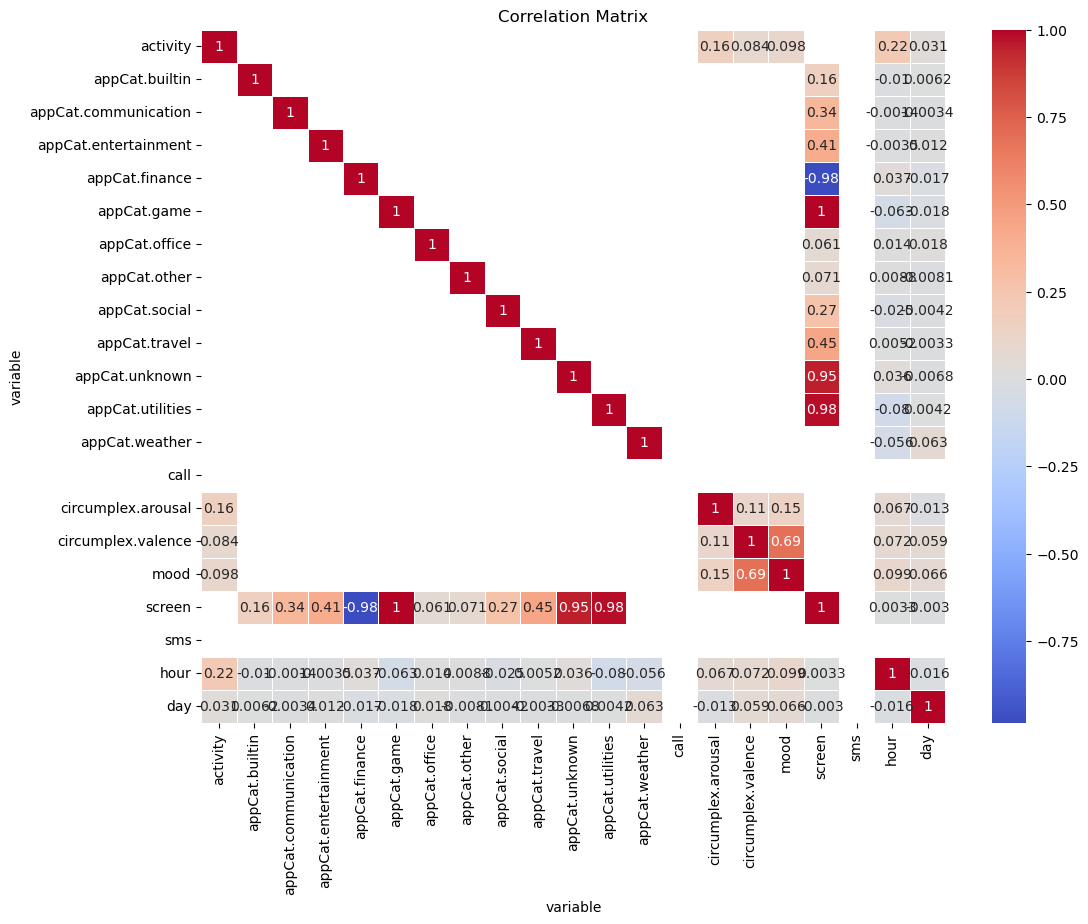

In [8]:
corr = data.corr()
plt.figure(figsize=(12, 9))
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [9]:
# # remove rows where appCat.builtin and appCat.entertainment	are negative
# data_wide = data_wide[(data_wide['appCat.builtin'] >= 0) & (data_wide['appCat.entertainment'] >= 0)]
# data_wide

In [19]:
# how many nan values are in mood column?
data['mood'].isna().sum()

353298

In [16]:
# sum variables
sum_vars = ['appCat.builtin', 'appCat.communication', 'appCat.entertainment', 
                 'appCat.finance', 'appCat.game', 'appCat.office', 'appCat.other', 
                 'appCat.social', 'appCat.travel', 'appCat.unknown', 'appCat.utilities', 
                 'appCat.weather', 'screen', 'call', 'sms']
# mean variables
mean_vars = ['circumplex.arousal', 'circumplex.valence', 'activity', 'mood']

# group the wide data by day and id and aggregate the sum and mean of the variables
grouped_wide = data.groupby([pd.Grouper(key='time', freq='D'), 'id']).agg({**{var: 'sum' for var in sum_vars}, **{var: 'mean' for var in mean_vars}})
grouped_wide

variable            appCat.builtin  appCat.communication  \
time       id                                              
2014-02-17 AS14.01           0.000                 0.000   
           AS14.02           0.000                 0.000   
           AS14.03           0.000                 0.000   
           AS14.06           0.000                 0.000   
           AS14.08           0.000                 0.000   
...                            ...                   ...   
2014-06-05 AS14.24        1749.277               958.821   
2014-06-06 AS14.24         945.898              1710.924   
2014-06-07 AS14.24        5027.498               735.965   
2014-06-08 AS14.24         351.389               375.515   
2014-06-09 AS14.24           0.000                 0.000   

variable            appCat.entertainment  appCat.finance  appCat.game  \
time       id                                                           
2014-02-17 AS14.01                   0.0             0.0          0.0   
           AS14.02                   0.0             0.0          0.0   
           AS14.03                   0.0             0.0          0.0   
           AS14.06                   0.0             0.0          0.0   
           AS14.08                   0.0             0.0          0.0   
...                                  ...             ...          ...   
2014-06-05 AS14.24                   0.0             0.0          0.0   
2014-06-06 AS14.24                   0.0             0.0          0.0   
2014-06-07 AS14.24                   0.0             0.0          0.0   
2014-06-08 AS14.24                   0.0             0.0          0.0   
2014-06-09 AS14.24                   0.0             0.0          0.0   

variable            appCat.office  appCat.other  appCat.social  appCat.travel  \
time       id                                                                   
2014-02-17 AS14.01            0.0         0.000          0.000          0.000   
           AS14.02            0.0         0.000          0.000          0.000   
           AS14.03            0.0         0.000          0.000          0.000   
           AS14.06            0.0         0.000          0.000          0.000   
           AS14.08            0.0         0.000          0.000          0.000   
...                           ...           ...            ...            ...   
2014-06-05 AS14.24            0.0        47.360        171.964        225.737   
2014-06-06 AS14.24            0.0        36.414          0.000          0.000   
2014-06-07 AS14.24            0.0         6.214        106.850          0.000   
2014-06-08 AS14.24            0.0        18.069        190.760          0.000   
2014-06-09 AS14.24            0.0         0.000          0.000          0.000   

variable            appCat.unknown  appCat.utilities  appCat.weather  \
time       id                                                          
2014-02-17 AS14.01             0.0             0.000             0.0   
           AS14.02             0.0             0.000             0.0   
           AS14.03             0.0             0.000             0.0   
           AS14.06             0.0             0.000             0.0   
           AS14.08             0.0             0.000             0.0   
...                            ...               ...             ...   
2014-06-05 AS14.24             0.0             0.000             0.0   
2014-06-06 AS14.24             0.0             2.072             0.0   
2014-06-07 AS14.24             0.0             0.000             0.0   
2014-06-08 AS14.24             0.0             0.000             0.0   
2014-06-09 AS14.24             0.0             0.000             0.0   

variable                 screen  call  sms  circumplex.arousal  \
time       id                                                    
2014-02-17 AS14.01     0.000000   2.0  0.0                 NaN   
           AS14.02     0.000000   4.0  2.0                 NaN   
           AS1

In [11]:
# show data for one id and one day
grouped_wide.sample(1)

,variable,appCat.builtin,appCat.communication,appCat.entertainment,appCat.finance,appCat.game,appCat.office,appCat.other,appCat.social,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather,screen,circumplex.arousal,circumplex.valence,activity,mood
time,id,,,,,,,,,,,,,,,,,
2014-05-04,AS14.20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.666667,NaN,7.333333


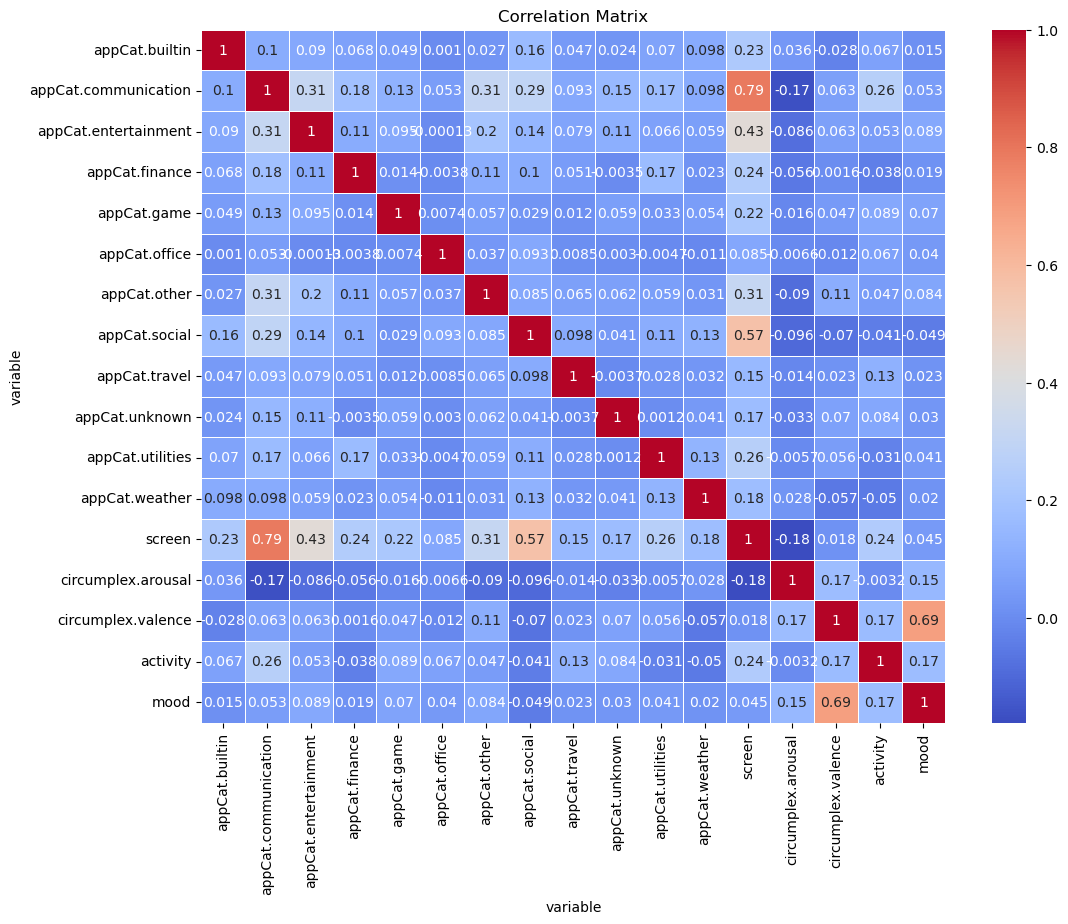

In [12]:
# correlation matrix of the aggregated variables
corr = grouped_wide.corr()
plt.figure(figsize=(12, 9))
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()


In [13]:
from itertools import cycle

palette = sns.color_palette("husl", n_colors=len(data.id.unique()))
color_cycle = cycle(palette)

for i in data.id.unique():
    current_color = next(color_cycle)
    plt.figure(figsize=(12, 6)) 
    sns.lineplot(
        data=data[data.id == i], 
        x='time', 
        y='mood', 
        color=current_color, 
        marker='o',  # Show data points as dots
        linestyle='--'  # Make the lines dashed
    )
    plt.title(i)
    plt.savefig('plots/timeseries/' + i + '.png')
    plt.clf()

/var/folders/cl/gr0w_0nd5b98g5nsjqhms9t40000gn/T/ipykernel_23599/522674978.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12, 6))


<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

In [14]:
# for every variable, plot the distribution
vars = ['mood']
for var in vars:
    if var not in ['id', 'time']:
        sns.histplot(data, x=var, kde=True)
        plt.title(f'Distribution of {var}')
        plt.xlabel(var)
        plt.ylabel('Frequency')
        # save plot
        plt.savefig('plots/distribution/' + var + '.png')
        plt.clf()

<Figure size 640x480 with 0 Axes>

## TASK 1C: FEATURE ENGINEERING

## Modelling

14:45:20 - cmdstanpy - INFO - Chain [1] start processing
14:45:20 - cmdstanpy - INFO - Chain [1] done processing


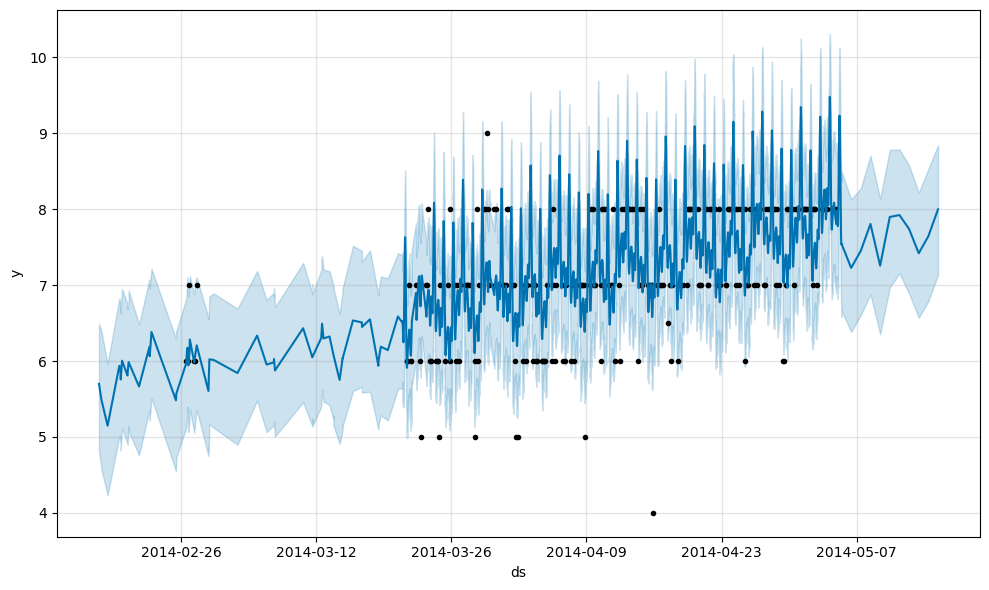

In [15]:
# select random id as data
df_prophet = data[data.id == 'AS14.01']

# Prepare the data
data['time'] = pd.to_datetime(data['time'])
df_prophet = df_prophet.rename(columns={'time': 'ds', 'mood': 'y'})

# Initialize the model
model = Prophet()

# Fit the model on the dataset
model.fit(df_prophet)

# Make future predictions
future = model.make_future_dataframe(periods=10)  # predict the next 'periods' days
forecast = model.predict(future)

# Plot the forecast
fig = model.plot(forecast)